In [1]:
from transformers import BertTokenizer, BertModel, AlbertTokenizerFast, AlbertModel
import torch
import torch.nn.functional as F
import re
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Data loading + making equations

In [2]:
def get_equation(reaction,reaction_rate):
    neg, delim ,pos =re.split(r'(<->|->|<-)', reaction, maxsplit=1)
    all_terms = ["-" + term for term in neg.split("+")]
    all_terms.extend(pos.split("+"))
    all_terms.append(reaction_rate)
    equation = (" = ".join(all_terms)).replace(" null =","")
    return equation

In [40]:
data = pd.read_csv("/home/jovyan/work/dufourspitze_16/data/final_table.csv", index_col=0)
data['equations'] = data.apply(lambda row: get_equation(row['reaction'], row['reaction rate']), axis=1)
data

,reaction,reaction rate,description,simplified_reaction,equations
reaction number,,,,,
1,[Blood-Lymph].CTLA4_mabB <-> Lymph_Node.CTLA4_mab,Kpa_LNB*S_LNB*VL*f_LN_CTLA4*([Blood-Lymph].CTL...,Distribution of Anti-CTLA-4 mAb between the ce...,alpha.CE <-> delta.CD,-[Blood-Lymph].CTLA4_mabB = Lymph_Node.CTLA4...
2,[Blood-Lymph].CTLA4_mabB <-> Peripheral.CTLA4_...,0.67*Q_L*[Blood-Lymph].CTLA4_mabB*(1-Sigma1_CT...,Distribution of Anti-CTLA-4 mAb between the ce...,alpha.CE <-> epsilon.CG,-[Blood-Lymph].CTLA4_mabB = Peripheral.CTLA4...
3,[Blood-Lymph].CTLA4_mabB <-> Peripheral.CTLA4_...,0.33*Q_L*[Blood-Lymph].CTLA4_mabB*(1-Sigma2_CT...,Distribution of Anti-CTLA-4 mAb between the ce...,alpha.CE <-> epsilon.CH,-[Blood-Lymph].CTLA4_mabB = Peripheral.CTLA4...
4,[Blood-Lymph].CTLA4_mabB <-> Tumor.CTLA4_mabt,Kpa_TB*S_TB*Vt_avg_const*[Blood-Lymph].CTLA4_m...,Distribution of Anti-CTLA-4 mAb between the ce...,alpha.CE <-> zeta.CJ,-[Blood-Lymph].CTLA4_mabB = Tumor.CTLA4_mabt...
5,[Blood-Lymph].CTLA4_mabB -> null,Cl_CTLA4*[Blood-Lymph].CTLA4_mabB,Clearance of Anti-CTLA-4 mAb from the central ...,alpha.CE -> null,-[Blood-Lymph].CTLA4_mabB = Cl_CTLA4*[Blood-...
...,...,...,...,...,...
444,Tumor.PDL1_mabt + Tumor.[C3=PDL1] <-> Tumor.[C...,[kon_PDL1-PDL1mAb]*Tumor.PDL1_mabt*Tumor.[C3=P...,Interaction at the immunological synapse betwe...,zeta.GI + zeta.[BE] <-> zeta.[BE:aPDL1],-Tumor.PDL1_mabt = - Tumor.[C3=PDL1] = Tumo...
445,Tumor.PDL1_mabt + Tumor.[T13a=PDL1] <-> Tumor....,[kon_PDL1-PDL1mAb]*Tumor.PDL1_mabt*Tumor.[T13a...,Interaction at the immunological synapse betwe...,zeta.GI + zeta.[IE] <-> zeta.[IE:aPDL1],-Tumor.PDL1_mabt = - Tumor.[T13a=PDL1] = Tu...
446,Tumor.PDL1_mabt + Tumor.[T2=PDL1] <-> Tumor.[T...,[kon_PDL1-PDL1mAb]*Tumor.PDL1_mabt*Tumor.[T2=P...,Interaction at the immunological synapse betwe...,zeta.GI + zeta.[JI] <-> zeta.[JI:aPDL1],-Tumor.PDL1_mabt = - Tumor.[T2=PDL1] = Tumo...


In [41]:
data['equations'][1]

'-[Blood-Lymph].CTLA4_mabB  =  Lymph_Node.CTLA4_mab = Kpa_LNB*S_LNB*VL*f_LN_CTLA4*([Blood-Lymph].CTLA4_mabB/Vc_CTLA4-Lymph_Node.CTLA4_mab/VL)'

### Getting the Embeddings

In [6]:
def get_bert_tokenizer_and_model(tokenizer_path, model_path):
    tokenizer = BertTokenizer.from_pretrained(tokenizer_path)
    model = BertModel.from_pretrained(model_path)
    return tokenizer, model

def get_albert_tokenizer_and_model(tokenizer_path, model_path):
    tokenizer = AlbertTokenizerFast.from_pretrained(tokenizer_path)
    model = AlbertModel.from_pretrained(model_path)
    return tokenizer, model

def get_embedding(tokenizer, model, text):
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True)
    
    with torch.no_grad():  
        outputs = model(**inputs)
    embeddings = outputs.last_hidden_state
    return embeddings


In [7]:
math_albert_path = "AnReu/albert-for-arqmath-3"
desc_bert_path = "bert-base-uncased"

In [8]:
mtokenizer, mmodel = get_albert_tokenizer_and_model(math_albert_path, math_albert_path)
dtokenizer, dmodel = get_bert_tokenizer_and_model(desc_bert_path, desc_bert_path)

Some weights of the model checkpoint at AnReu/albert-for-arqmath-3 were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [42]:
rcn_embs =torch.cat([get_embedding(mtokenizer, mmodel, equation)[:,:2,:].view(1,-1) for equation in data['reaction']])
rate_embs =torch.cat([get_embedding(dtokenizer, dmodel, desc)[:,:2,:].view(1,-1) for desc in data['reaction rate']])
eq_embs =torch.cat([get_embedding(mtokenizer, mmodel, equation)[:,:2,:].view(1,-1) for equation in data['equations']])
desc_embs =torch.cat([get_embedding(dtokenizer, dmodel, desc)[:,:2,:].view(1,-1) for desc in data['description']])

### Cosine Similarity as a sanity check

In [43]:
eq_sim = cosine_similarity(eq_embs,eq_embs)
desc_sim = cosine_similarity(desc_embs, desc_embs)

Text(0.5, 1.0, 'Similarity of Equations')

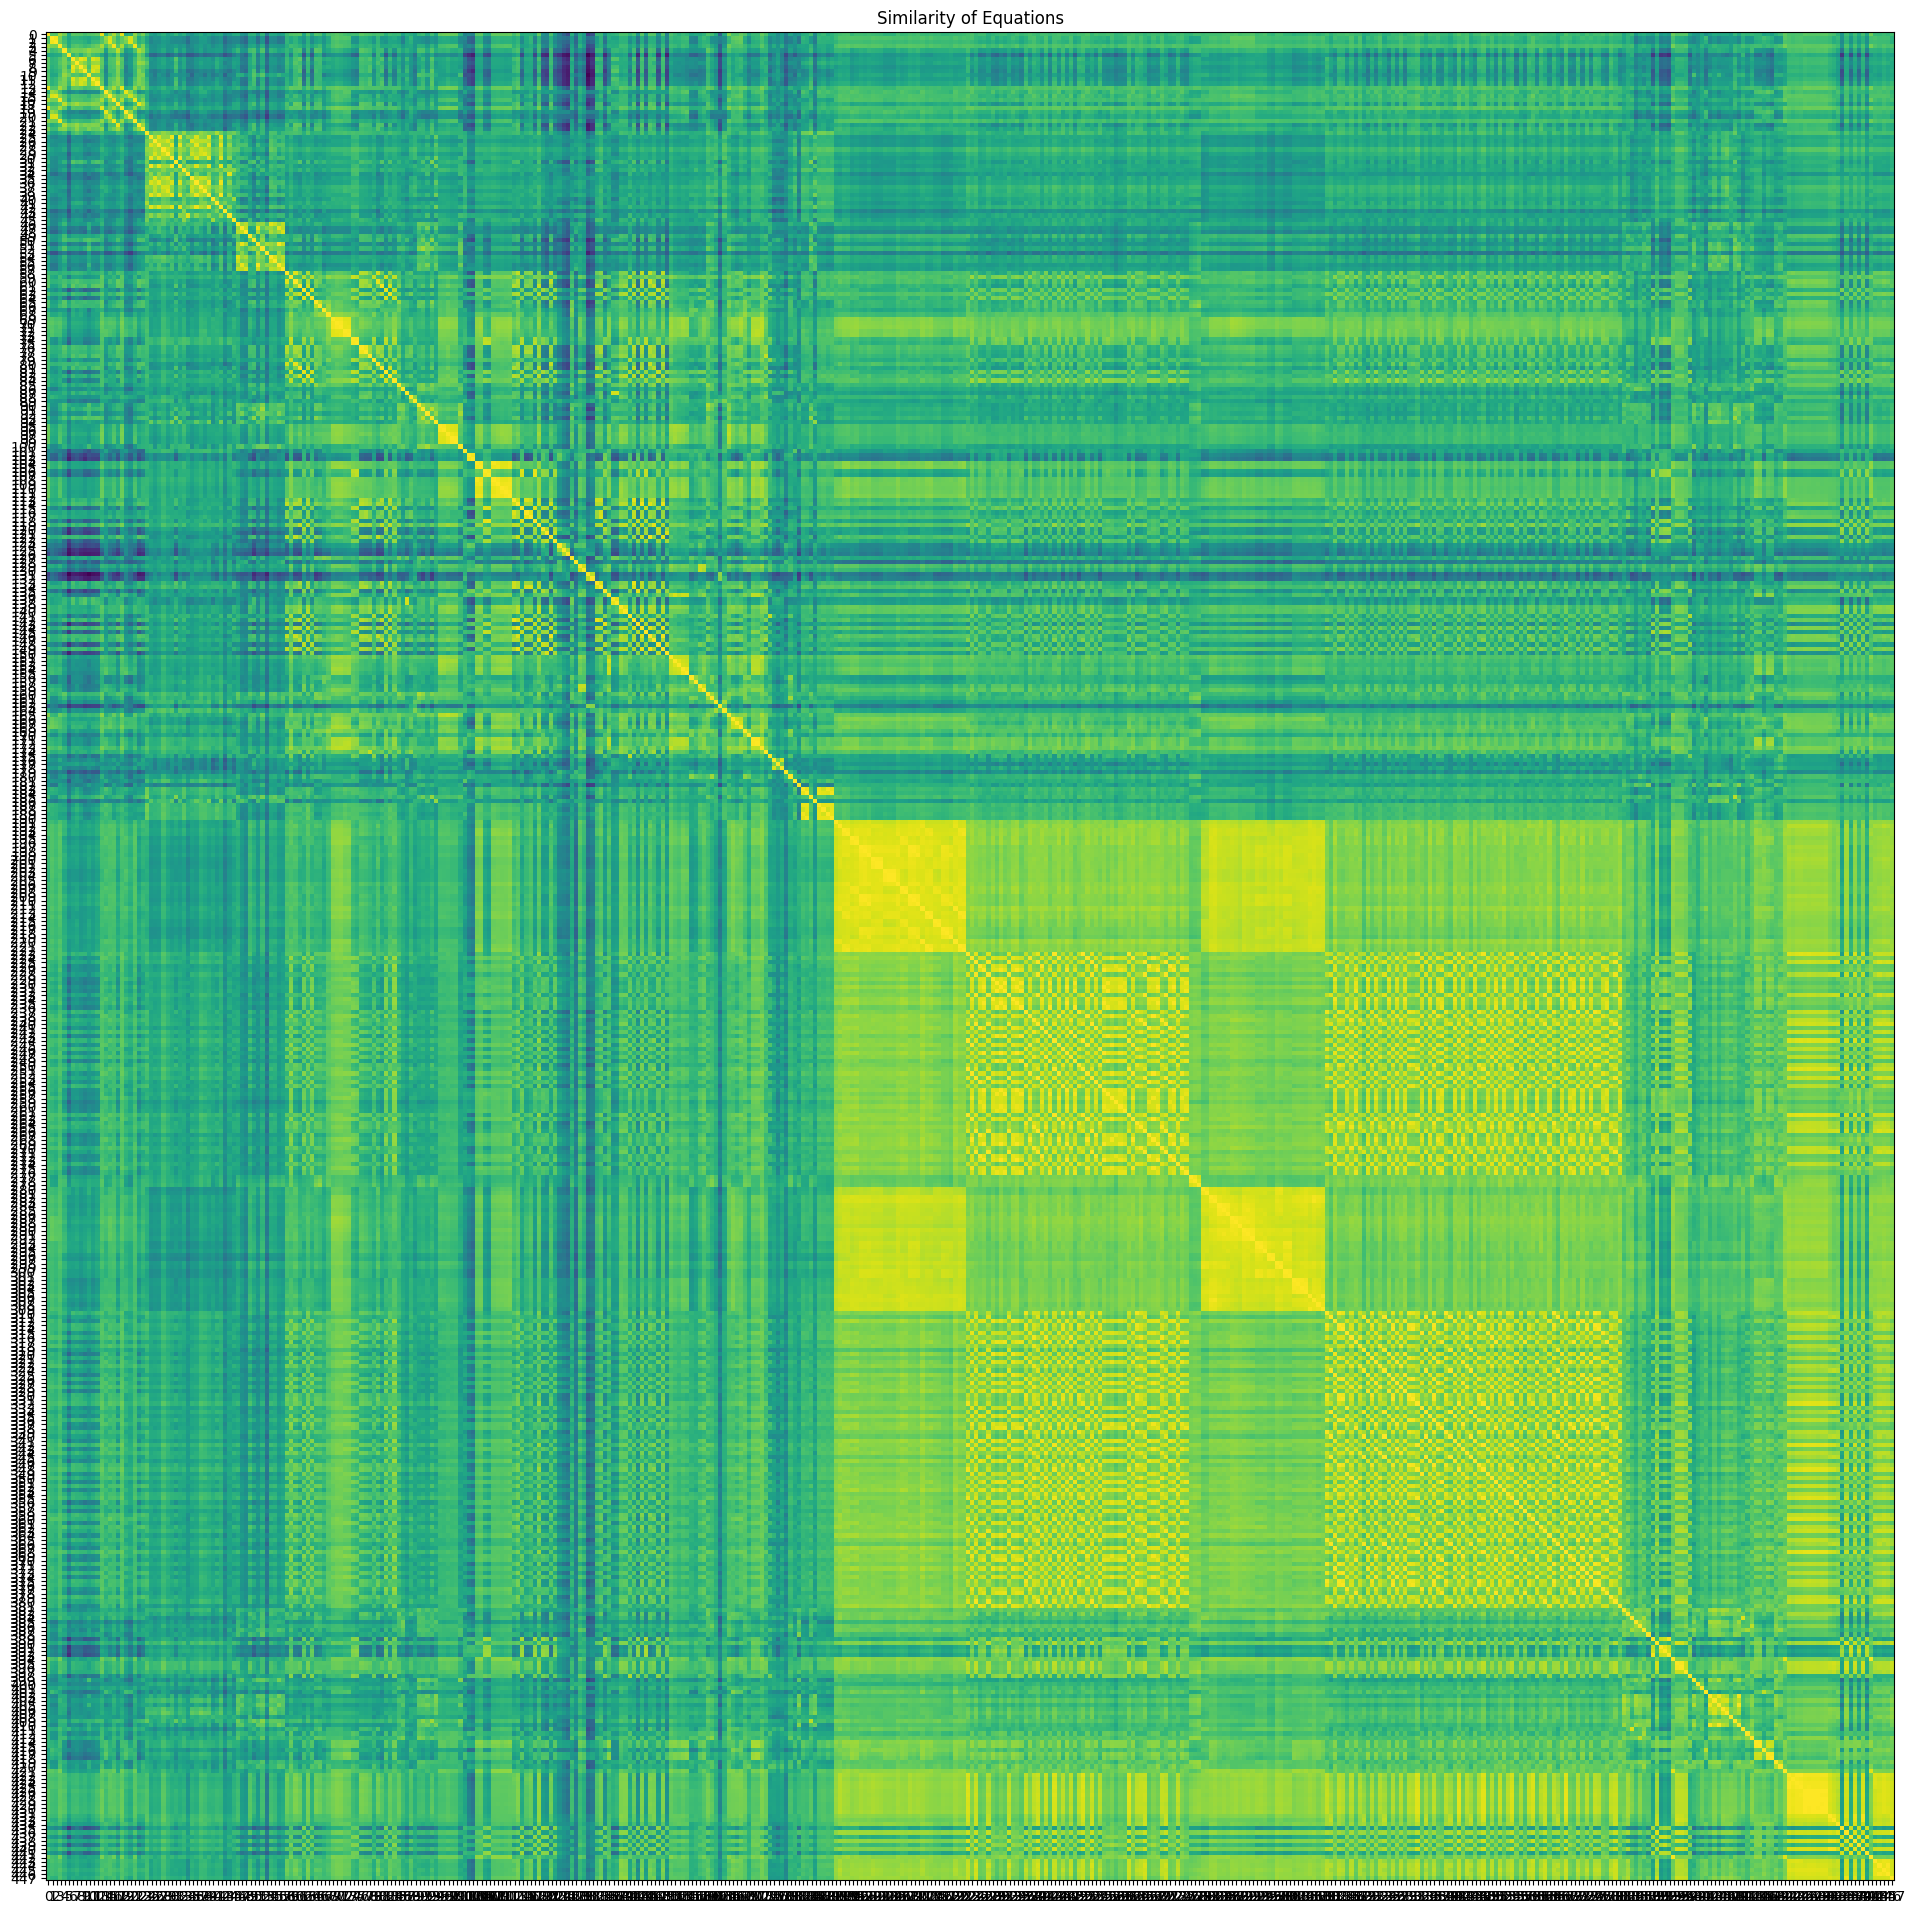

In [44]:
plt.figure(figsize=(24,24))
plt.xticks(range(eq_sim.shape[0]))
plt.yticks(range(eq_sim.shape[0]))
plt.imshow(eq_sim)
plt.title("Similarity of Equations")

Text(0.5, 1.0, 'Similarity of Descriptions')

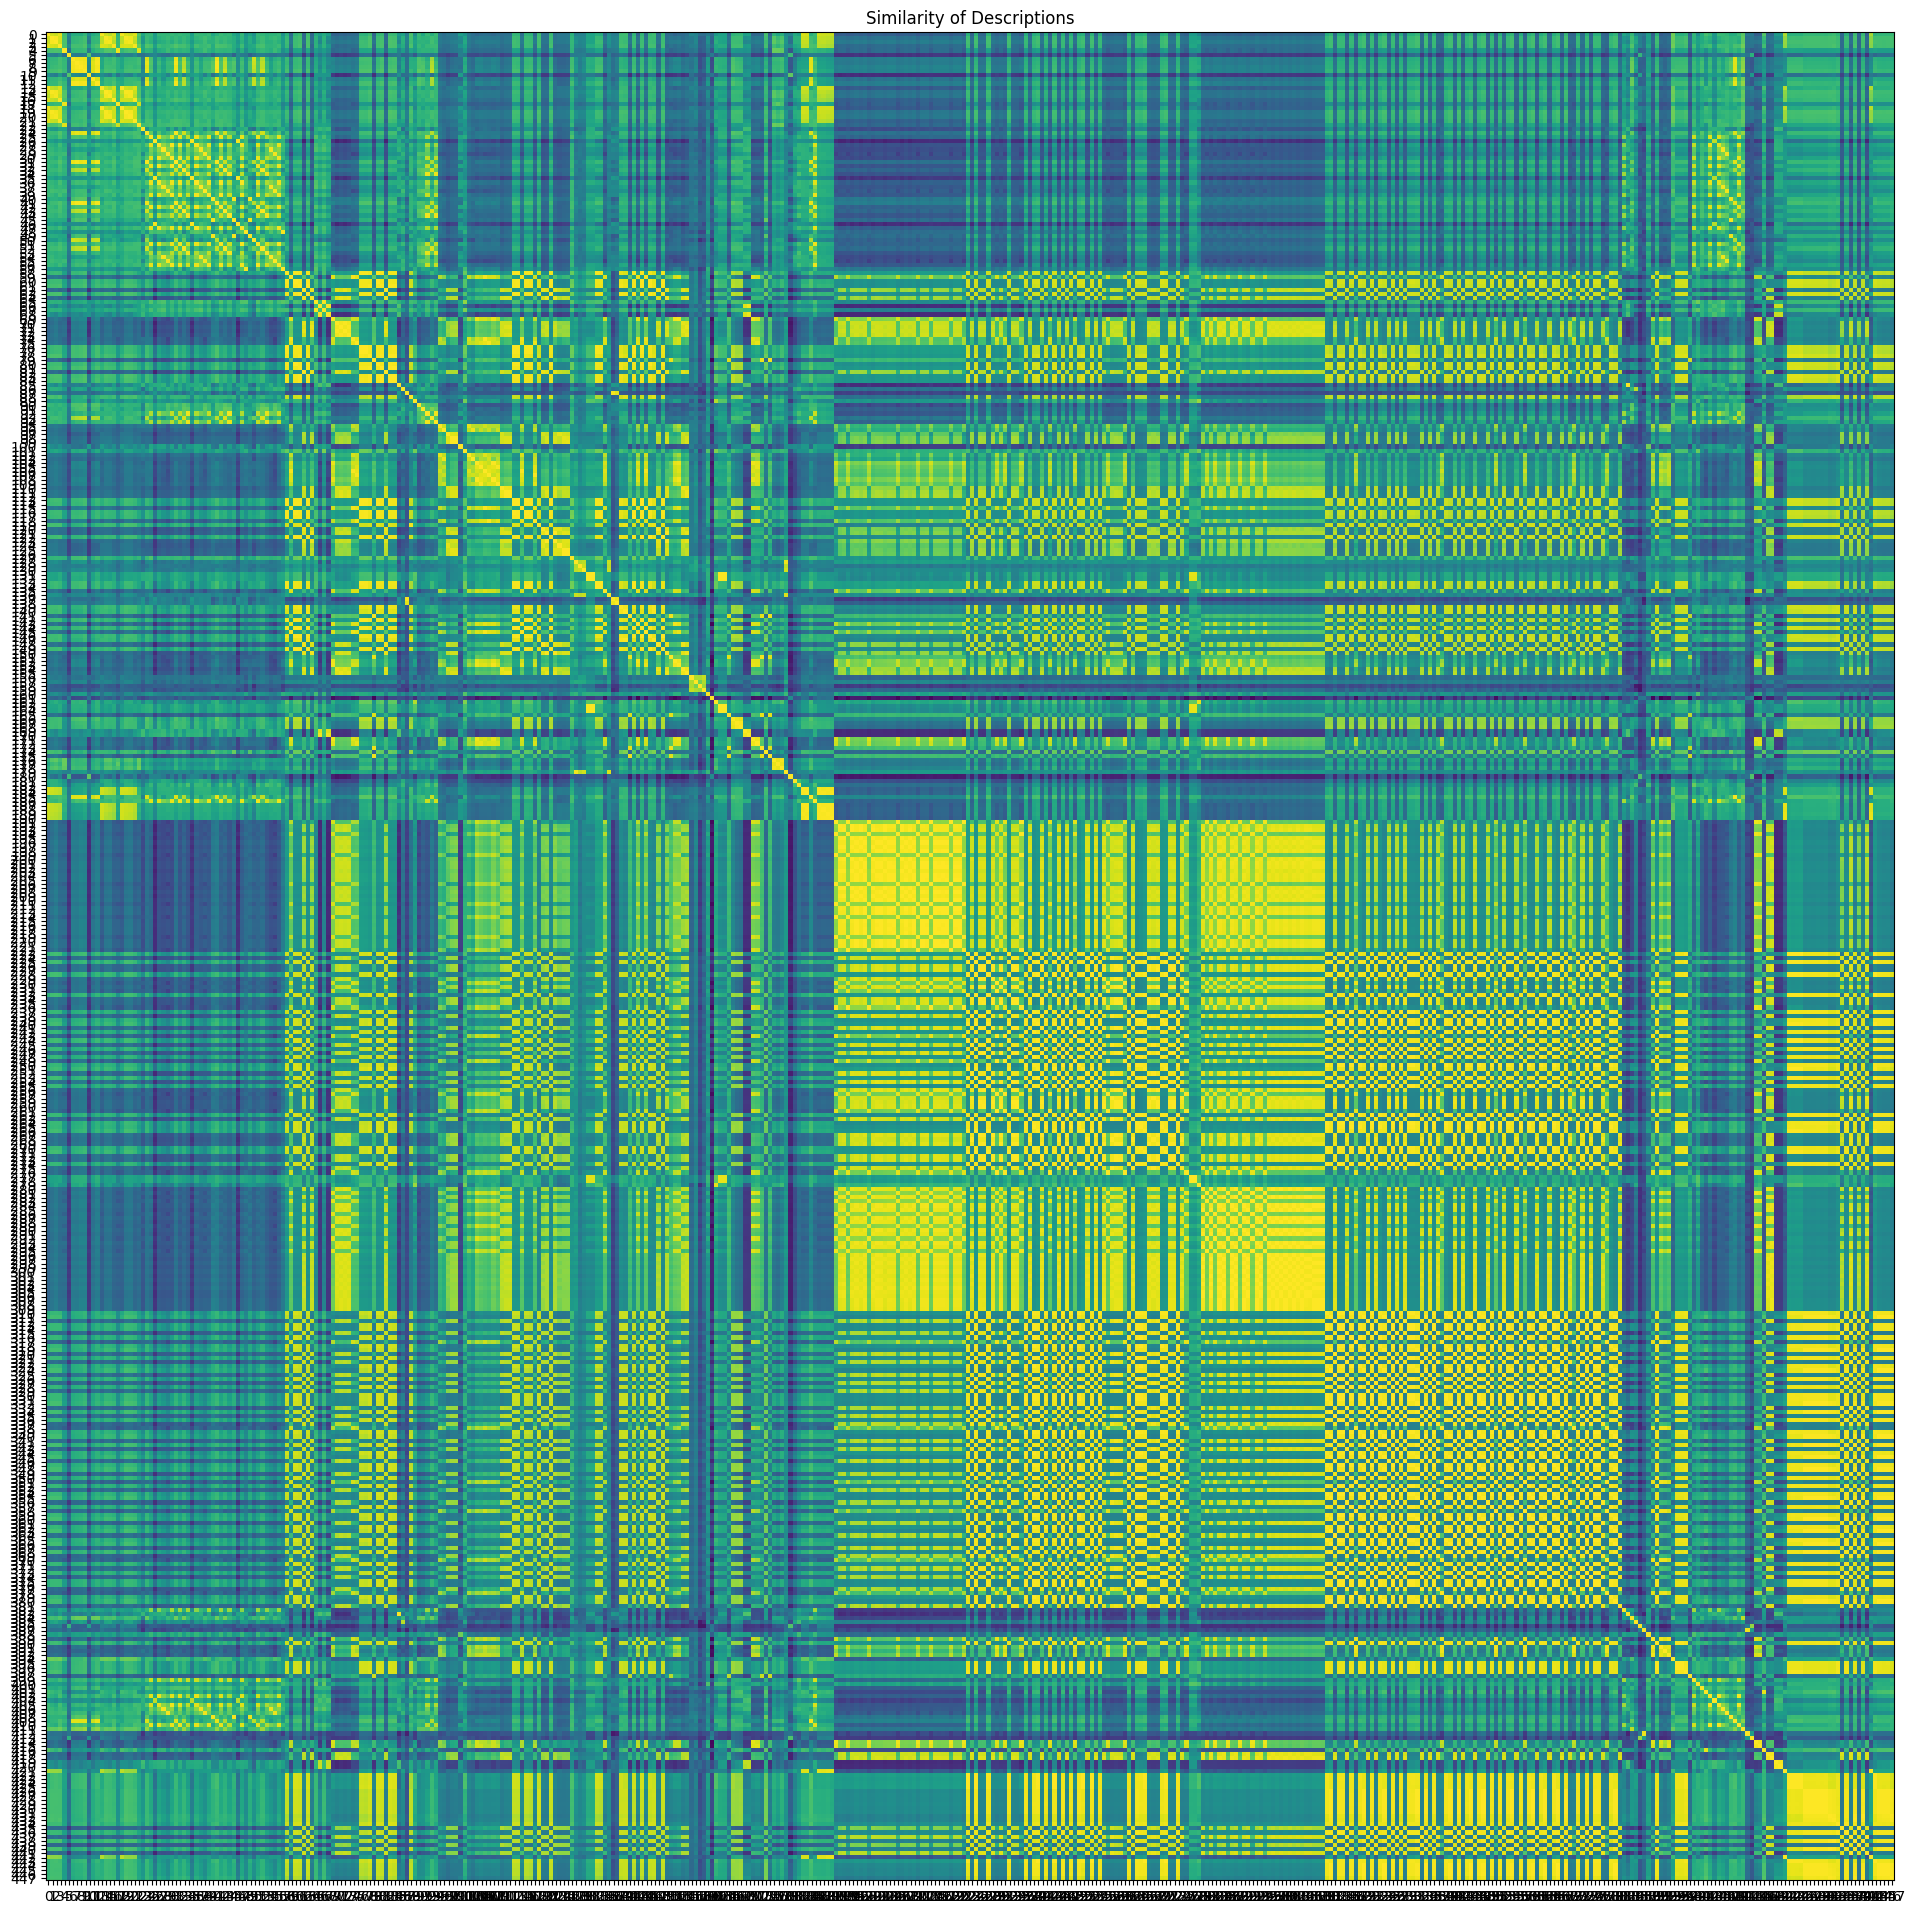

In [45]:
plt.figure(figsize=(24,24))
plt.xticks(range(eq_sim.shape[0]))
plt.yticks(range(eq_sim.shape[0]))
plt.imshow(desc_sim)
plt.title("Similarity of Descriptions")

### Lets try some visualization to see if things cluster nicely - TSNE?

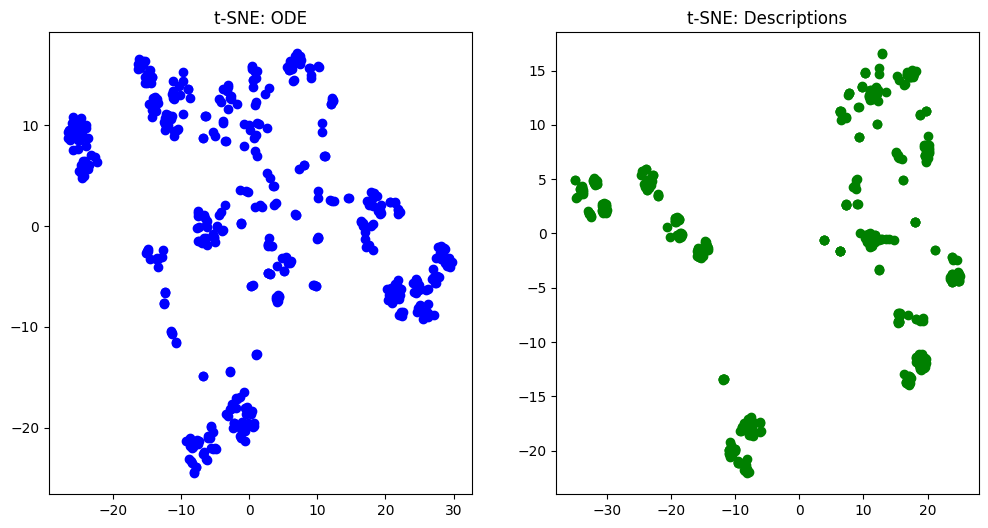

In [46]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne_A = TSNE(n_components=2, random_state=42, metric="cosine")
tsne_embeddings_A = tsne_A.fit_transform(eq_embs)
tsne_B = TSNE(n_components=2, random_state=42, metric="cosine")
tsne_embeddings_B = tsne_B.fit_transform(desc_embs)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(tsne_embeddings_A[:, 0], tsne_embeddings_A[:, 1], color='blue', label='Equations')
plt.title("t-SNE: ODE")
plt.subplot(1, 2, 2)
plt.scatter(tsne_embeddings_B[:, 0], tsne_embeddings_B[:, 1], color='green', label='Descriptions')
plt.title("t-SNE: Descriptions")

plt.show()


### Are clusters based on  equations good predictors of description clusters?

In [47]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn import preprocessing

from sklearn.neighbors import NearestNeighbors
n_clusters = 5  
kmeans_A = KMeans(n_clusters=n_clusters, random_state=42).fit(preprocessing.normalize(eq_embs))
kmeans_B = KMeans(n_clusters=n_clusters, random_state=42).fit(preprocessing.normalize(desc_embs))

labels_A = kmeans_A.labels_
labels_B = kmeans_B.labels_
nn_model = NearestNeighbors(n_neighbors=1, metric='cosine')
nn_model.fit(desc_embs)
correct_matches = 0
for i, embedding_A in enumerate(eq_embs):
    distance, index = nn_model.kneighbors([embedding_A], return_distance=True)
    if labels_A[i] == labels_B[index[0][0]]:
        correct_matches += 1

accuracy = correct_matches / len(eq_embs)
print(f"Cross-modal cluster matching accuracy: {accuracy * 100:.2f}%")

Cross-modal cluster matching accuracy: 22.54%


### PCA now

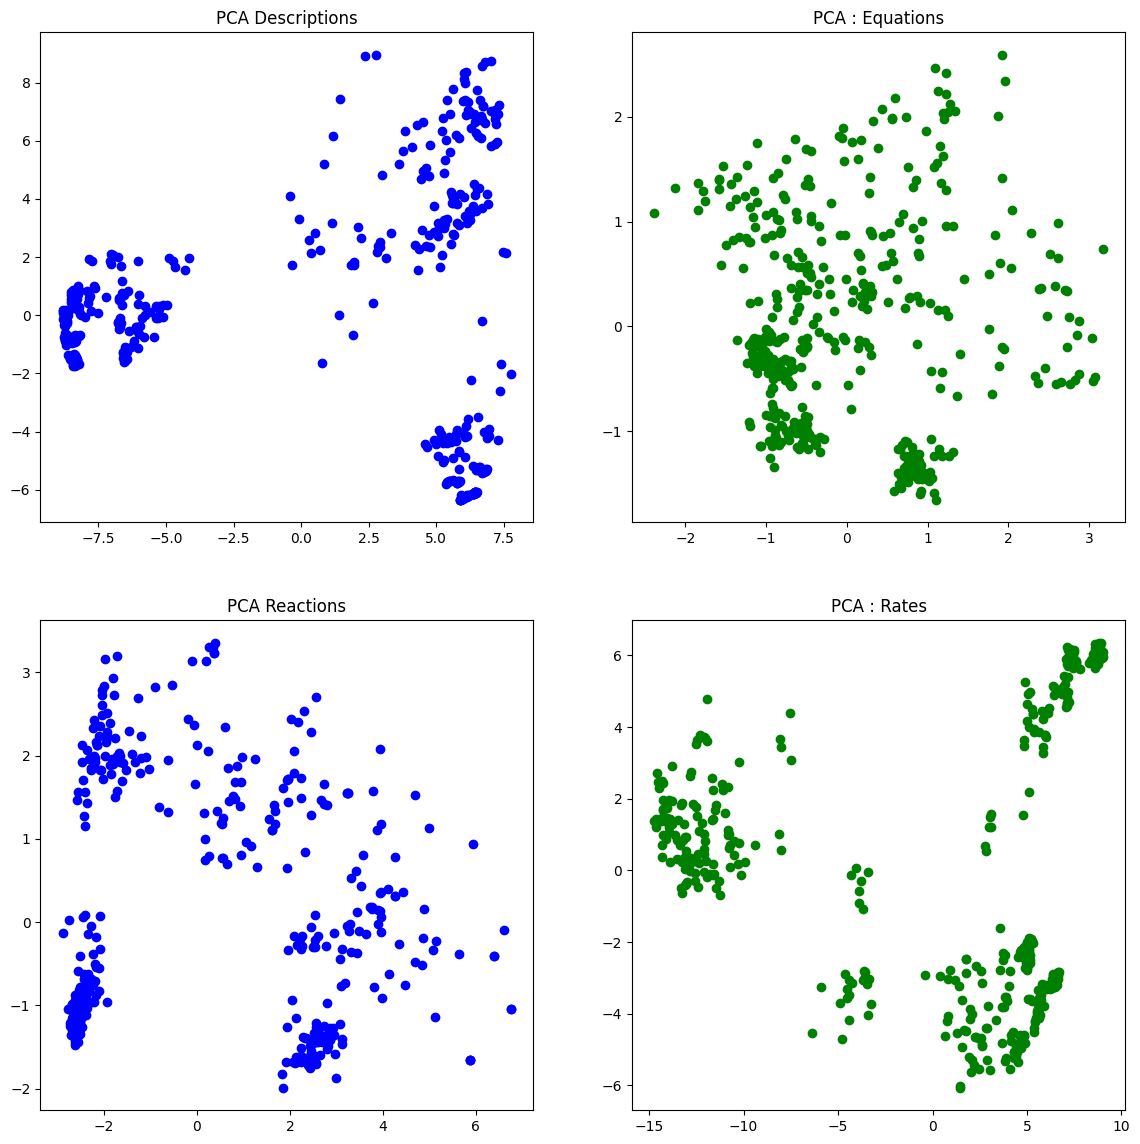

In [48]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 10)
eq_red = pca.fit_transform(eq_embs)
desc_red = pca.fit_transform(desc_embs)
rcn_red = pca.fit_transform(rcn_embs)
rate_red = pca.fit_transform(rate_embs)
plt.figure(figsize=(14,14))
plt.subplot(2, 2, 1)
plt.scatter(desc_red[:, 0], desc_red[:, 1], color='blue', label='Descriptions')
plt.title("PCA Descriptions")
plt.subplot(2, 2, 2)
plt.scatter(eq_red[:, 0], eq_red[:, 1], color='green', label='Equations')
plt.title("PCA : Equations")
plt.subplot(2, 2, 3)
plt.scatter(rcn_red[:, 0], rcn_red[:, 1], color='blue', label='Reactions')
plt.title("PCA Reactions")
plt.subplot(2, 2, 4)
plt.scatter(rate_red[:, 0], rate_red[:, 1], color='green', label='Rates')
plt.title("PCA : Rates")
plt.show()

### Let's try to query now

In [68]:
from sklearn.mixture import GaussianMixture

def do_gmm_stuff(X, red_X, nc, text):
    gmm = GaussianMixture(n_components=nc, covariance_type='full', random_state=0)
    gmm.fit(red_X)
    labels = gmm.predict(red_X)
    plt.figure(figsize=(8, 6))
    plt.scatter(red_X[:, 0], red_X[:, 1], c=labels, cmap='viridis', marker='o', edgecolor='k', s=50)
    
    plt.title(f"GMM Clustering : {text}")
    plt.xlabel("PCA Feat 1")
    plt.ylabel("PCA Feat 2")
    plt.show()
    return labels


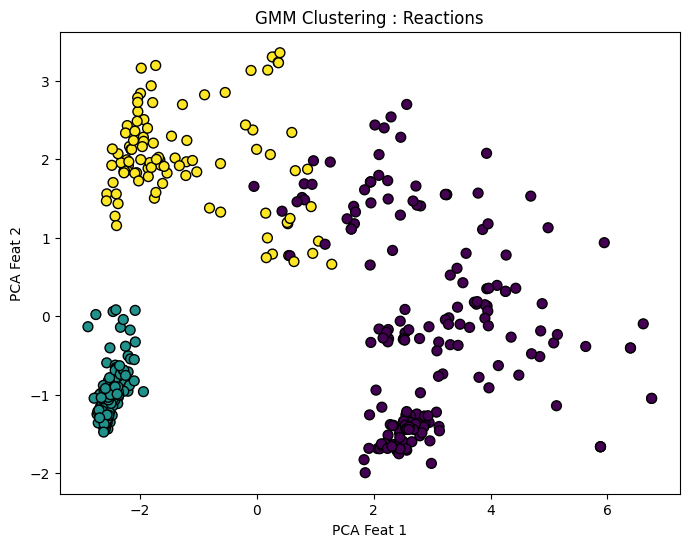

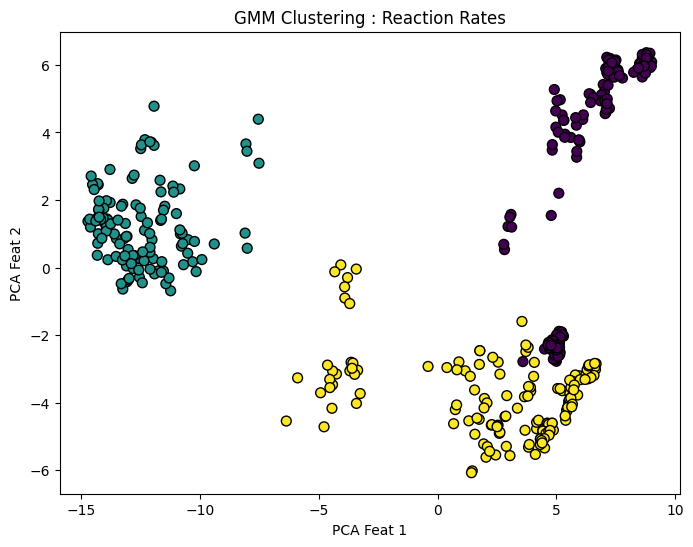

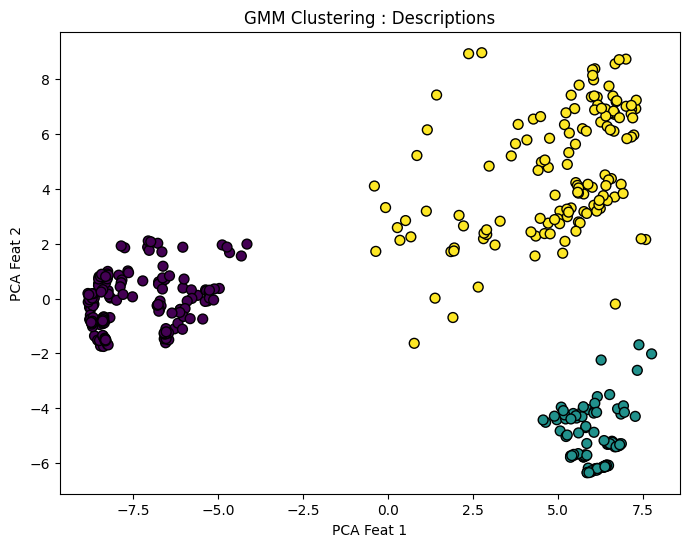

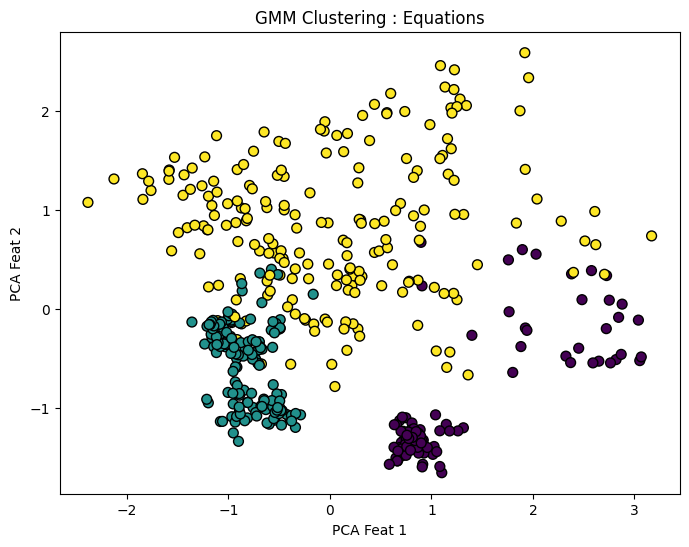

In [69]:
rcn_labels =do_gmm_stuff(rcn_embs, rcn_red,3, "Reactions")
rate_labels =do_gmm_stuff(rate_embs, rate_red,3, "Reaction Rates")
desc_labels =do_gmm_stuff(desc_embs, desc_red,3, "Descriptions")
eqn_labels =do_gmm_stuff(eq_embs, eq_red,3, "Equations")


In [72]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, adjusted_mutual_info_score

ari = adjusted_rand_score(rcn_labels, desc_labels)
nmi = normalized_mutual_info_score(rcn_labels, desc_labels)
ami = adjusted_mutual_info_score(rcn_labels, desc_labels)

# Print the results
print("Adjusted Rand Index (ARI):", ari)
print("Normalized Mutual Information (NMI):", nmi)
print("Adjusted Mutual Information (AMI):", ami)

ari = adjusted_rand_score(rate_labels, desc_labels)
nmi = normalized_mutual_info_score(rate_labels, desc_labels)
ami = adjusted_mutual_info_score(rate_labels, desc_labels)

# Print the results
print("Adjusted Rand Index (ARI):", ari)
print("Normalized Mutual Information (NMI):", nmi)
print("Adjusted Mutual Information (AMI):", ami)

ari = adjusted_rand_score(eqn_labels, desc_labels)
nmi = normalized_mutual_info_score(eqn_labels, desc_labels)
ami = adjusted_mutual_info_score(eqn_labels, desc_labels)

# Print the results
print("Adjusted Rand Index (ARI):", ari)
print("Normalized Mutual Information (NMI):", nmi)
print("Adjusted Mutual Information (AMI):", ami)

Adjusted Rand Index (ARI): 0.1709607089210652
Normalized Mutual Information (NMI): 0.20687986982636694
Adjusted Mutual Information (AMI): 0.20354494950270163
Adjusted Rand Index (ARI): 0.4103853926814692
Normalized Mutual Information (NMI): 0.4608889800493503
Adjusted Mutual Information (AMI): 0.4586442671253728
Adjusted Rand Index (ARI): 0.35051972561322814
Normalized Mutual Information (NMI): 0.4233129164086218
Adjusted Mutual Information (AMI): 0.4208661449362087
